In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Generate Training Data</h3>

**In other words, solve the forward problem**

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set number of Fourier basis
nfb = 128

# set radius of spatial domain
radius = 16

# create vector of real space points for plotting
nx = 1024
xvec = np.linspace(-radius, radius, nx)

# matrix to convert Fourier basis coefficients
# into real space values
nvec = np.arange(-nfb, nfb+1)
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / radius) / np.sqrt(2 * radius)

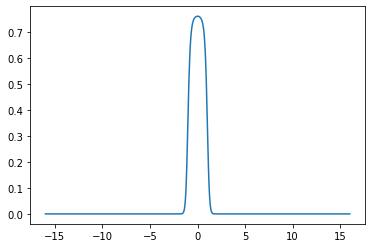

In [4]:
# this code creates ainit from psi0

psi0choice = 0
def genainit():
    def psi0(x, choice=0):
        if choice == 0:
            # rounded box function
            return 1.0 + np.tanh((1 - x**2)/0.5)
        elif choice == 1:
            # triangular pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
        elif choice == 2:
            # parabolic pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
        elif choice == 3:
            # hyperbolic secant squared
            return (np.cosh(x))**(-2)
        elif choice == 4:
            # Laplace
            return np.exp(-np.abs(x))
        else:
            print('Function psi0(x, choice=0): Did not recognise your choice.')
            return None

    # normalize psi0
    norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-radius, b=radius)[0])
    def normpsi0(x):
        return psi0(x)/norm

    # transform psi0 to Fourier basis using quadrature method
    vraw = np.zeros(nfb+1, dtype=np.complex128)
    for thisn in range(nfb+1):
        def integ(x):
            return (2 * radius) ** (-0.5) * np.exp(-1j * np.pi * thisn * x / radius) * normpsi0(x)
        def rinteg(x):
            return np.real(integ(x))
        def iinteg(x):
            return np.imag(integ(x))
        vraw[thisn] = si.quad(rinteg, a=-radius, b=radius)[0] + 1j * si.quad(iinteg, a=-radius, b=radius)[0]

    return np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

ainit = genainit()

# plot real part of ainit
plt.plot(xvec, np.real(ainit @ convmat))
plt.show()

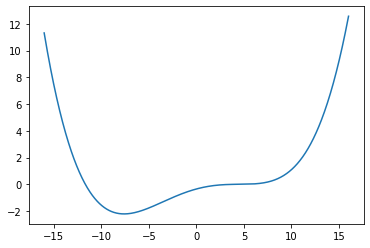

In [5]:
# define potential for generating training data

def v(x, choice=0):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Function v(x, choice=0): Choice not recognised.')
        return None

# compute true potential
vchoice = 2
vtrue = v(xvec, choice=vchoice)

# plot true potential
plt.plot(xvec, vtrue)
plt.show()

In [6]:
# set number of Gaussian basis
ng = 16

# vector of Gaussian basis centers in real space
xg = np.linspace(-radius, radius, ng)

---
**Find Optimal Alpha**

In [7]:
def grecminfn(alpha):
    grecgmat = np.exp(-alpha * (xg[:,np.newaxis] - xg)**2)
    grecgmatplot = np.exp(-alpha * (xvec[:, np.newaxis] - xg) ** 2)

    coeffs = nl.inv(grecgmat) @ v(xg, choice=vchoice)
    greconvtrue = np.einsum('...bc, ...c', grecgmatplot, coeffs)
    # quantify difference between real and reconstructed potentials
    normval = nl.norm(greconvtrue - vtrue)
    # scale norms so ranges from 0 to 1
    scalednorm = normval / nl.norm(vtrue)

    condnum = nl.cond(grecgmat)
    logcondnum = np.log(condnum)

    # I know the log of the condition number for alpha=0.01 is
    # about 30. The condition number is monitonically decreasing
    # so this is pretty close to as high as this value will be
    # thus this is like a sudo maximum value
    return scalednorm + logcondnum / 30

In [8]:
minalpha = so.minimize(grecminfn, x0=0.5, method='BFGS', jac='3-point', options={'disp': True}).x
print(minalpha)

Optimization terminated successfully.
         Current function value: 0.066390
         Iterations: 3
         Function evaluations: 15
         Gradient evaluations: 5
[0.60175385]


In [20]:
# this code computes the gradient of the potential matrix
# for the Gaussian basis, this is constant
k = np.pi * np.arange(0, 2*nfb+1) / radius
expmat = np.exp((-k**2 / (4*minalpha))[:, np.newaxis] + (-1j*k[:,np.newaxis]*xg))
gvmatcnst = (1 / (2 * radius)) * np.sqrt(np.pi / minalpha) * expmat
gradgvmat = np.zeros((ng, 2*nfb+1, 2*nfb+1), dtype=np.complex128)
for i in range(ng):
    gradgvmat[i,:]=toeplitz(gvmatcnst.T[i].conj(), gvmatcnst.T[i])

# this code computes the potential matrix (in the Fourier basis)
# given a set of Gaussian basis coefficients
# @njit
def gvmat(cff):
    # cff is the vector containing the Gaussian basis coefficients
    # njit can't multiply together arrays of different types
    # so first convert cff to complex type
    cplxcff = cff.astype(np.complex128)
    if len(cplxcff.shape) == 1:
        # coefficients are time-independent
        column = gvmatcnst @ cplxcff
        row = column.conj()
        return toeplitz(r=row, c=column)
    elif len(cplxcff.shape) == 2:
        # coefficients are time-dependent
        rtn = np.zeros((cplxcff.shape[0], nfb, nfb), dtype=np.complex128)
        for i in range(cplxcff.shape[0]):
            thiscolumn = gvmatcnst @ cplxcff[i]
            thisrow = thiscolumn.conj()
            rtn[i] = toeplitz(r=thisrow, c=thiscolumn)
        return rtn
    else:
        # error
        print('Function gvmat(cff): cff has unexpected shape')
        return None

---

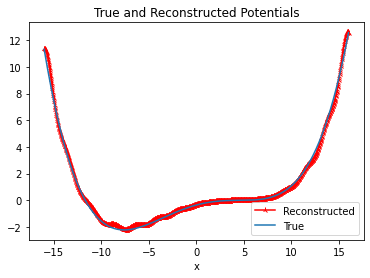

Relative Norm Difference: 0.05786991413169762


In [15]:
# this code computes the coefficients of the true potential in the
# Gaussian basis using minalpha (determined above)

# this is used for computing the Gaussian basis coefficients
gmat = np.exp(-minalpha * (xg[:,np.newaxis] - xg)**2)

# this is used for converting the Gaussian basis coefficients
# to real space values
gmatplot = np.exp(-minalpha * (xvec[:,np.newaxis] - xg)**2)

# this computes the Gaussian basis coefficients
# of the true potential
# We use gmat and v(xg) here because we need
# both of them to be square matrices
cfftrue = nl.inv(gmat) @ v(xg, choice=vchoice)

# reconstruct the potential from the Gaussian basis coefficents
vrecontrue = gmatplot @ cfftrue

# plot real potential vs. reconstructed potential
plt.plot(xvec, vrecontrue, '2-r', label='Reconstructed')
plt.plot(xvec, vtrue, label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

print('Relative Norm Difference:', nl.norm(vrecontrue - vtrue) / nl.norm(vtrue))

---
**Functions for Propagating System Given Some amat**

In [16]:
# number of elements for toeplitz representation
m = 2*nfb + 1

# set the time step size for propagating
dt = 0.01

# set the number of steps to propagate "a" vector in time
nt = 200

In [29]:
gvmat(np.tile(cfftrue, (nt, 1)))

ValueError: could not broadcast input array from shape (257,257) into shape (128,128)

In [ ]:

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * radius ** 2))

@njit
def propa(cff, initacff, timependcff=np.zeros(ng, dtype=float)):
    # form static potential matrix from Gaussian coefficients
    vmatstatcff = gvmat(cff)

    # form time-dependent potential matrix from time-dependent
    # Gaussian coefficients (will be a an nt by ng matrix)

    # construct Hamiltonian matrix (in Fourier basis)
    hmatcff = kmat + vmatstatcff

    # diagonalize the Hamiltonian matrix (eigendecomposition)
    speccff, statescff = np.linalg.eigh(hmatcff)

    # form the propagator matrices
    propamat = statescff @ np.diag(np.exp(-1j*speccff*dt)) @ np.conj(statescff.T)
    proplammat = statescff @ np.diag(np.exp(1j*speccff*dt)) @ np.conj(statescff.T)

    # propagate the a vector, i.e., solve the *forward* problem
    amatcff = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    amatcff[0,:] = np.copy(initacff)
    for j in range(nt):
        amatcff[j+1,:] = propamat @ amatcff[j,:]

    return speccff, statescff, amatcff, proplammat

In [43]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

@njit
def proplam(amatcff, thisamattrue, proplammat):
    lambmat = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    lambmat[nt,:] = amatcff[nt,:] - thisamattrue[nt, :]

    for j in range(nt-1,0,-1):
        lambmat[j,:] = amatcff[j,:] - thisamattrue[j, :] + proplammat @ lambmat[j + 1, :]
    
    return lambmat

---
**Compute True amat**

In [44]:
# this code propagates ainit using hmattrue produce amattrue

spectrue, statestrue, amattrue, _ = propa(cfftrue, ainit)

# transform amat to real space
psimattrue = amattrue @ convmat

# check if psimattrue is normalized for every time step
# this should return something close to 1
print( np.sum( np.sqrt( np.sum( np.abs(amattrue) ** 2, axis=1) ) )/nt )

1.0049999987336191


**Adjoint Method Code**

In [45]:
# this code computes the Lagrangian the input cff here
# is the vector of modeling parameters

def justlag(cffprdt):
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat
    global glbproplammat
    
    # propagate ainit with cffprdt
    glbspecprdt, glbstatesprdt, glbamatprdt, glbproplammat = propa(cffprdt, ainit)
    
    # propagate lambmat with glbamatprdt
    glblambmat = proplam(glbamatprdt, amattrue, glbproplammat)
    
    # compute Lagrangian
    resid = glbamatprdt - amattrue
    lag = 0.5 * np.real( np.sum( np.conj(resid) * resid ) )
    
    print('Lagrangian:', lag, end='\r')
    return lag
    

In [46]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradhelp(specprdt, statesprdt):
    alldmat = np.zeros((ng, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*specprdt)
    mask = np.zeros((m,m), dtype=np.complex128)

    for ii in range(m):
        for jj in range(m):
            if np.abs(specprdt[ii] - specprdt[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(specprdt[ii]-specprdt[jj]))
    
    for iii in range(ng):
        thisA = statesprdt.conj().T @ gradgvmat[iii] @ statesprdt
        qmat = thisA * mask
        alldmat[iii,:,:] = -1j*dt* statesprdt @ qmat @ statesprdt.conj().T

    return alldmat
        
def justgrad(_):
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat
    global glballdmat
    
    # compute alldmat
    glballdmat = gradhelp(glbspecprdt, glbstatesprdt)

    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblambmat[1:,:]), glballdmat, glbamatprdt[:-1,:]))

    return gradients

**Check Functions Using True $\theta$**

In [47]:
# check if the Lagrangian of the true theta, xtrue, gives 0
# justlag(xtrue)
print('\n', justlag(cfftrue))

# check if the gradient of the Lagrangian is zero for the true theta, xtrue
print(justgrad(None))

Lagrangian: 0.0
 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---
**Initialize theta with uniform random values**

In [48]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

cffform = np.random.uniform(size=cfftrue.shape) - 0.5

In [49]:
# minimize to find predicted theta

resform = so.minimize(justlag, cffform, jac=justgrad, method='BFGS',
                      options={'disp': True, 'maxiter': 100, }).x

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 84
         Function evaluations: 87
         Gradient evaluations: 87


Lagrangian for theta:  4.4075788936030834e-07
Norm difference theta:  0.5022603624362898
Prediction vs. Truth:  6.427603529775814
Prediction vs. Training:  2.5713534945803955


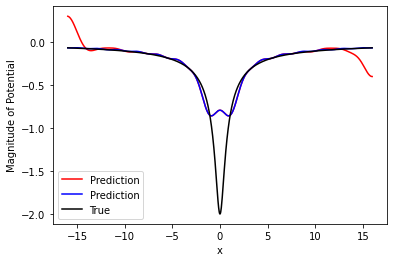

In [50]:
# results

# print value of Lagrangian for predicted theta
print('Lagrangian for theta: ', justlag(resform))

# check how close predicted theta are to true theta
print('Norm difference theta: ', nl.norm(resform - cfftrue))

# use the machine learned theta to compute the predicted potential
vformprdc = gmatplot @ resform

# check how close the predicted potential is to the true potential
print('Prediction vs. Truth: ', nl.norm(vtrue - vformprdc))

# check how close the predicted potential is to the training data
print('Prediction vs. Training: ', nl.norm(vrecontrue - vformprdc))

# red = learned potential
# blue = reconstructed potentila (training data)
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vrecontrue[trim:-trim], color='blue', label='Prediction')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('x')
plt.ylabel('Magnitude of Potential')
#plt.ylim(-100, 1000)
plt.legend()
plt.show()

**Propagate System with Predicted Potential**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


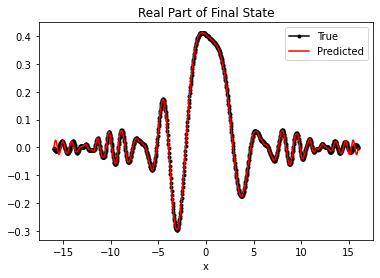

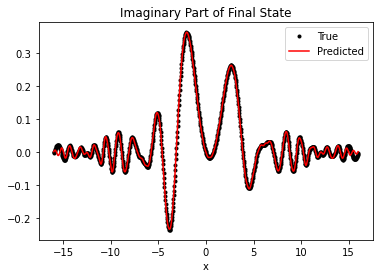

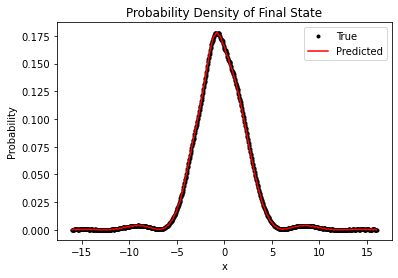

In [30]:
# propagate ainit using the predicted theta
_, _, amatform, _ = propa(resform.x, ainit)
    
# transform amat to real space
psimatform = amatform @ convmat

print('Element difference:\n', psimatform[-1] - psimattrue[-1])
print('Norm of difference:', nl.norm(psimatform - psimattrue))

plt.plot(xvec, psimattrue[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattrue[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattrue[-1])**2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()